## DeepLoop training procedure

This notebook outlines the full training procedure for *DeepLoop*. It relies on *HiCorr* (https://github.com/JinLabBioinfo/HiCorr) correct Hi-C datasets but you are free to try any form of Hi-C dataset.

Note: You will need a GPU for training. While using pretrained weights to denoise/enhance Hi-C data is feasible on a CPU (~30 minutes per genome), training requires much more compute power. This notebook is just for demonstration. If you plan on fully training a model, you should be running the training scripts on a machine with a GPU.

In [118]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'  # force tensorflow to run on CPU
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

### LoopDenoise combination

To train a LoopDenoise model, we generate training targets consisting of only highly reproducible pixels. This can be done with the `combine_replicates_by_p_value.py` script. You will need *HiCorr* corrected interactions and p-values for all three replicates and the pooled data. By default we use $p<0.05$ to indicate significance.

In [ ]:
! python3 ../LoopDenoise/combine_replicates_by_p_value.py --replicates ../training_data/H9_reps/ \
                                           --fulldata ../training_data/H9_full/ \
                                           --anchors ../training_data/anchor_bed/ \
                                           --output h9_combined_output \
                                           --pmax 0.05 \
                                           --union True;

This will produce a new set of anchor to anchor interaction files which will be used as the training targets. It also produces a summary file of the interactions used during combination in each chromosome:

In [38]:
df = pd.read_csv('fullcomb.summary')

print('%.2f +/- %.2f %% signals kept' % (df['percent_kept'].mean(), df['percent_kept'].std()))


def chr_to_int(chrom):
    res = chrom.replace('chr', '')
    if res == 'X':
        return 23
    elif res == 'Y':
        return 24
    else:
        return int(res)

df['chr'] = df['chr'].apply(chr_to_int)

4.91 +/- 3.32 % signals kept


In [55]:
df

,Unnamed: 0,1_only,2_only,3_only,full,1&2&3,1&2~3,1~2&3,~12&3,chr,percent_kept,training_target
0,0,193351,252020,196035,1141414,43037,41784,28426,44217,1,7.371546,440905
1,1,326893,433919,331064,1882676,78665,73784,44988,77493,2,11.032076,738281
2,2,194373,282609,203402,1244516,41970,44779,25856,49866,3,8.553645,475943
3,3,242867,371362,257183,1579244,50520,58961,31525,66934,4,11.195564,612952
4,4,173819,254446,180872,1138990,34423,40092,23132,43819,5,8.556211,433248
5,5,139983,195169,145240,903080,28564,30589,19156,33160,6,7.182155,340359
6,6,95649,128870,98363,623786,18362,19870,13356,21391,7,5.603615,231541
7,7,104062,144387,107625,679570,20732,22354,14122,23987,8,6.356245,254147
8,8,42226,57786,44427,301432,6301,8046,6028,8880,9,3.450480,108883
9,9,50707,70520,53708,357262,8361,10079,7049,11151,10,3.668627,129934


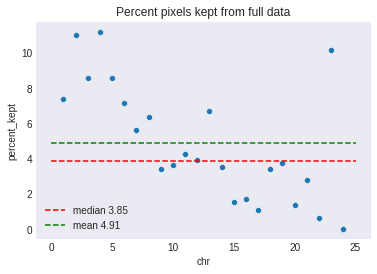

In [56]:
sns.scatterplot(x='chr', y='percent_kept', data=df)
plt.hlines(df['percent_kept'].median(), 0, 25, label='median %.2f' % df['percent_kept'].median(), colors='red', linestyles='dashed')
plt.hlines(df['percent_kept'].mean(), 0, 25, label='mean %.2f' % df['percent_kept'].mean(), colors='green', linestyles='dashed')
plt.legend()
plt.title('Percent pixels kept from full data')
plt.show()

### LoopDenoise training

Now we can use these reproducible loop pixels as training targets in the LoopDenoise training process. The `hi_c_denoise.py` script can be used to train new LoopDenoise models with custom datasets.

In [ ]:
! python3 ../LoopDenoise/hi_c_denoise.py --noisy_dir ../training_data/H9_reps/ \
                                         --target_dir h9_combined_output/ \
                                         --anchor_dir ../training_data/anchor_bed/ \
                                         --experiment_name h9_denoise_sample \
                                         --epochs 50;